# Importando as bibliotecas

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import plot, show, legend
from collections import Counter
import seaborn as sn
import os
import sys
sys.path.insert(0, os.path.abspath('../Util'))
from dados import ProcessarDados
#from sklearn.metrics import plot_confusion_matrix

In [44]:
# Dataset

In [3]:
procData = ProcessarDados("../dataset/norm_bin_10_FEATURES_M17_CM6b_TH199.csv")

In [46]:
# Funções

In [50]:
# funcção que treina e testa o modelo armazenando as métricas
# retorna um dicionário cotendo os valores das métricas de cada rodada
def treinamento_teste(epocas = 10, k_folds = 5, exibir_matriz_confusao=False, exibir_metricas=False):
    
    #array para armazenar as das métricas de cada rodada
    resultados_accuracy = []
    resultados_precision = []
    resultados_recall = []
    resultados_specificity = [] # taxa de verdadeiros negativos ou especificidade
    resultados_f2 = []
    resultados_parametros = []
    resultados_matriz = []

    
    #dicionário das métricas
    resultados_gerais = {}

    for i in range(epocas):
        # divisão os dados 
        seed = i
        X_train, X_test, y_train, y_test = procData.holdout(0.2, seed)
        #print(Counter(y_test))

        # realizando o grid search para encontrar a melhor K-Vizinhos e pesos, 
        # considerando a acurácia (taxa de acerto)
        # aqui o método GridSearchCV é configurado para subdividir os dados de treino em k_folds
        clf = KNeighborsClassifier()
        grid_knn = GridSearchCV(clf, param_grid, cv=k_folds, scoring='accuracy', verbose=0)
        grid_knn.fit(X_train, y_train)
        
        
        ####CV_RESULTS  
        # plot results
        means = grid_knn.cv_results_['mean_test_score']
        scores = np.array(means).reshape(len(pesos), len(n_neighbors))
        
        for i, value in enumerate(pesos):
            plt.plot(n_neighbors, scores[i], label='Distância: ' + str(value))
        plt.legend()
        plt.xlabel('N_vizinhos')
        plt.ylabel('Acurácia')

        
        # Treinando do modelo com os melhores parametros encontrados
        grid_knn.best_params_
        Kvizinhos_best = int(grid_knn.best_params_['n_neighbors']) 
        p_best = grid_knn.best_estimator_.p
        KNN = KNeighborsClassifier(n_neighbors=Kvizinhos_best, p=p_best, metric='minkowski')
        #KNN = KNeighborsClassifier(n_neighbors=Kvizinhos_best, metric='minkowski')
        KNN.fit(X_train, y_train)

        #testando o modelo
        y_pred = KNN.predict(X_test)
        cm  = confusion_matrix(y_test, y_pred)
        if exibir_matriz_confusao:
            print(cm)

        # calculado as metricas
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        # f2-score
        # Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
        beta = 0.5
        f2_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn+fp)

        # armazenando as métricas
        resultados_accuracy.append(accuracy)
        resultados_precision.append(precision)
        resultados_recall.append(recall)
        resultados_specificity.append(specificity)
        resultados_f2.append(f2_score)

        best_parametros = {'n_neighbors': Kvizinhos_best, 'p': p_best};
        #best_parametros = {'n_neighbors': Kvizinhos_best}
        resultados_parametros.append(best_parametros)



        if exibir_metricas:
            print("Rodada:",i)
            print("Parâmetros:",best_parametros)
            print("Accuracy:",accuracy)
            print("Precision:",precision)
            print("Recall:",recall)
            print("Specificity:",specificity)
            print("fb-Score:",f2_score)
            print("\n")

            
    resultados_gerais['accuracy'] = resultados_accuracy
    resultados_gerais['precision'] = resultados_precision
    resultados_gerais['recall'] = resultados_recall
    resultados_gerais['specificity'] = resultados_specificity
    resultados_gerais['f2'] = resultados_f2
    resultados_gerais['params'] = resultados_parametros
    
    return resultados_gerais

In [51]:
def tabelaMetricas(nome_modelo, dict_metricas, rodadas=False, salvarResultados=True):
        
    print ("============================================== "+nome_modelo+" =================================================")
    print ("=================================== RESULTADOS DAS MÉTRICAS DO MODELO ==============================")
    
    if(rodadas==False):
        print ("\t Accuracy \t|\t Precision \t|\t Recall \t|\tSpecificity \t|\t fb-Score")
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['accuracy'], axis=0), np.std(dict_metricas['accuracy'], axis=0)),end=' ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['precision'], axis=0), np.std(dict_metricas['precision'], axis=0)),end='  ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['recall'], axis=0), np.std(dict_metricas['recall'], axis=0)),end=' ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['specificity'], axis=0), np.std(dict_metricas['specificity'], axis=0)),end='   ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['f2'], axis=0), np.std(dict_metricas['f2'], axis=0)))
        print ("====================================================================================================")
        
    if(salvarResultados):
        # save to npy file
        np.save('../resultados/resultados_'+nome_modelo+'.npy', dict_metricas)

# Definindo os parâmetros

In [52]:
#K-Vizinhos
n_neighbors = np.arange(1,25)
#'uniforme': Todos os pontos em cada vizinho têm o mesmo peso.
#'distância': Inverso de sua distância, os vizinhos mais próximos de um ponto de consulta terão uma influência maior do que os vizinhos mais distantes.
pesos = [1,2]
param_grid = {'n_neighbors': n_neighbors, 'p': pesos}
#param_grid = {'n_neighbors': n_neighbors}
epocas = 1
k_folds = 5
exibir_matriz_confusao = True
exibir_metricas = True

# Treinando e obtendo as métricas do modelo

[[22  6]
 [ 7 85]]
Rodada: 1
Parâmetros: {'n_neighbors': 1, 'p': 2}
Accuracy: 0.8916666666666667
Precision: 0.9340659340659341
Recall: 0.9239130434782609
Specificity: 0.7857142857142857
fb-Score: 0.9320175438596493


============================================== KNN =================================================
=================================== RESULTADOS DAS MÉTRICAS DO MODELO ==============================
	 Accuracy 	|	 Precision 	|	 Recall 	|	Specificity 	|	 fb-Score
      0.8917 +- 0.0000       0.9341 +- 0.0000        0.9239 +- 0.0000       0.7857 +- 0.0000         0.9320 +- 0.0000


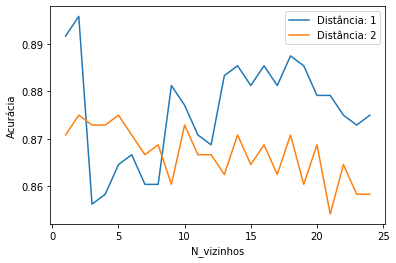

In [53]:
# treinando o modelo
dict_metricas = treinamento_teste(epocas, k_folds, exibir_matriz_confusao, exibir_metricas)
tabelaMetricas('KNN',dict_metricas)